# Protein sequence playing around

In [125]:
import numpy as np
import requests
import re
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

In [8]:
url = 'https://www.rcsb.org/pdb/rest/getCurrent'
response = requests.get(url) 
xml = response.text
xml = xml.split('\n')

In [21]:
pdbs = [re.search('structureId="(....)"',x)[1] for x in xml[2:-2]]

In [26]:
pdbs[:8]

['100D', '101D', '101M', '102D', '102L', '102M', '103D', '103L']

In [61]:
# randomly sample some PDBs
sample = np.random.choice(pdbs,10000,replace=False)

# extract all fasta sequences
all_seq = []
for i in sample:
    url = f'https://www.rcsb.org/pdb/rest/customReport.xml?pdbids={i.lower()}&customReportColumns=sequence'
    response = requests.get(url)
    txt = response.text
    root = ET.fromstring(txt)
    for child in root:
        for e in child:
            if (e.tag) == 'dimEntity.sequence':
                all_seq.append(e.text)  
                
len(all_seq)                

33336

In [63]:
# for future usage, I will save thes as a txt file for faster loading
import pickle

with open('fastas', 'wb') as out:
    pickle.dump(all_seq, out)

with open ('fastas', 'rb') as read:
    all_seq = pickle.load(read)

In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing import sequence

Using TensorFlow backend.


In [123]:
unique = set()
for s in all_seq:
    for a in s:
        unique.update(a)
''.join(unique)

'GULSKHlAVnCRWENTuFIMQDYPX'

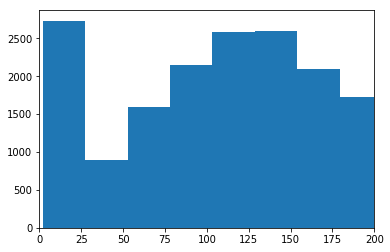

In [131]:
plt.hist([len(x) for x in all_seq],bins=200)
plt.xlim(0,200)
plt.show()

In [132]:
X_raw = [x for x in all_seq if len(x)>50]
len(X_raw)

29778

In [136]:
n_to_aa = {i:v for i,v in enumerate(unique)}
aa_to_n = {v:i for i,v in enumerate(unique)}

In [202]:
voc = len(unique)
win = 5

model = Sequential()
model.add(LSTM((15), input_shape=(win, voc)))
model.add(Dense(voc,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 15)                2460      
_________________________________________________________________
dense_20 (Dense)             (None, 25)                400       
Total params: 2,860
Trainable params: 2,860
Non-trainable params: 0
_________________________________________________________________


In [162]:
# prepare X and y
X_total = []
for x in X_raw:
    X_total.extend([(x[i:i+win],x[i+win]) for i in range(len(x)-(win))])
len(X_total)

8244480

In [197]:
# try a subsample

sample = 100000
test = 100000

indices = np.random.choice(range(len(X_total)),size=sample+test,replace=False)
total = np.array(X_total)[indices]

X = np.zeros((sample+test,win,voc),dtype=int)
y = np.zeros((sample+test,voc),dtype=int)

for i in range(sample+test):
    xy = total[i]
    X[i][range(win),[aa_to_n[i] for i in xy[0]]] = 1
    y[i][aa_to_n[xy[1]]] = 1   
    
X_train = X[:sample]
y_train = y[:sample]
X_test = X[sample:]
y_test = y[sample:]

In [198]:
X_train.shape,y_train.shape

((100000, 5, 25), (100000, 25))

In [ ]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
100000/100000 [==============================] - 30s 298us/step - loss: 2.8656 - acc: 0.1005
Epoch 2/10
100000/100000 [==============================] - 28s 276us/step - loss: 2.8189 - acc: 0.1061
Epoch 3/10
100000/100000 [==============================] - 27s 272us/step - loss: 2.8126 - acc: 0.1066
Epoch 4/10
100000/100000 [==============================] - 27s 271us/step - loss: 2.8091 - acc: 0.1073
Epoch 5/10
100000/100000 [==============================] - 27s 271us/step - loss: 2.8067 - acc: 0.1074
Epoch 6/10
100000/100000 [==============================] - 27s 268us/step - loss: 2.8052 - acc: 0.1087
Epoch 7/10
 59520/100000 [================>.............] - ETA: 10s - loss: 2.8060 - acc: 0.1075

In [ ]:
model.evaluate(X_test,y_test)